In [1]:
import warnings

import arviz as az 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import pymc3 as pm 
import seaborn as sns 

from scipy import stats 
from scipy.optimize import curve_fit

from sklearn import preprocessing

warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
az.rcParams["stats.hdi_prob"] = 0.89 # set default credible interval used by arviz
np.random.seed(0)

# The Haunted DAG and The Causal Terror

It seems like the most newsworthy scientific studies are the least trustworthy. Explanation: popular topics attract more and worse researchers? Actually all that is necessary for such a negative correlation to arise is that peer reviewers care about both newsworthiness and trustworthiness. The act of selection itself is enough to make the most newsworthy studies the least trustworthy.

Belos is a simple simulation that illustrate the point. We choose top 10% proposals for funding from a random samples of 200 proposals for scientific research. There is no correlation at all between trustworthiness (rigor, scholarship, plausibility of succcess) and newsworthiness (social welfar value, public interest). The general phenomenon has been recognized for a long time and called **BERKSON'S PARADOX**, or *selection-distortion effect*. 

In [3]:
np.random.seed(3)
N = 200
p = 0.1

# Uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)

# select top 10% of combined scores
s = nw + tw
q = np.quantile(s, 1-p)
selected = s >= q

cor = np.corrcoef(tw[selected], nw[selected])
print(cor)

[[ 1.         -0.74495204]
 [-0.74495204  1.        ]]


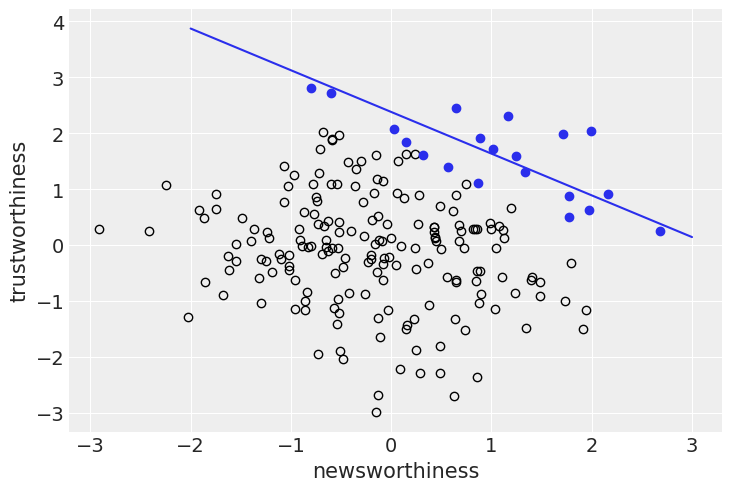

In [4]:
plt.scatter(nw[~selected], tw[~selected], lw=1, edgecolor="k", color=(0,0,0,0))
plt.scatter(nw[selected], tw[selected], color="C0")
xn = np.array([-2, 3])
plt.plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()))
plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness");

## Multicollinearity

Multicollinearity means very strong correlation between two or more predictor variables. The consequence of it is that the posterior distribution will seem to suggest that none of the variables is reliably associated with the outcome, even if all the variables are in reallity strongly associated with the outcome. 

The simulation's example is predicting an individual's height using the length of his legs as predictor variables. Surely height is positively associated with leg length. Nevertheless, once you put both leg lengths into the model, something vexing will happen.

### 1. The Leg Problem (Imagine)

In [5]:
N = 100
height = np.random.normal(10, 2, N)
leg_prop = np.random.uniform(0.4, 0.5, N)
leg_left = leg_prop*height + np.random.normal(0, 0.02, N)
leg_right = leg_prop*height + np.random.normal(0, 0.02, N)
d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=['height', 'leg_left', 'leg_right'])
d.describe()

,height,leg_left,leg_right
count,100.000000,100.000000,100.000000
mean,10.124550,4.527003,4.519692
std,1.921684,0.888728,0.891798
min,6.088466,2.556409,2.522770
25%,8.718338,3.885265,3.866763
50%,9.976485,4.454126,4.441732
75%,11.760332,5.161060,5.161976
max,13.739015,6.667998,6.660744


Before approximating the posterior, consider what we expect. On average, an individual legs are 45% ofo their height (in these simulated data). So we should expect the beta coefficient that measures the association of a leg with height to end up around the average height (10) divided by 45% of the average height (4.5). This is around 10/4.5 = 2.2.

In [6]:
with pm.Model() as m61:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    br = pm.Normal("br", 2, 10)
    mu = a + bl*d.leg_left + br*d.leg_right
    sigma = pm.Exponential("sigma", 1)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)
    m61_trace = pm.sample()
    idata61 = az.from_pymc3(m61_trace)
az.summary(idata61, round_to=2)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, br, bl, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.98,0.33,0.46,1.52,0.01,0.00,2404.10,2333.20,2404.56,1915.80,1.0
bl,-2.01,2.13,-5.15,1.53,0.06,0.04,1467.51,1289.18,1477.96,1504.93,1.0
br,4.03,2.12,0.48,7.14,0.06,0.04,1472.91,1344.69,1483.51,1554.95,1.0
sigma,0.64,0.05,0.57,0.71,0.00,0.00,2254.25,2240.73,2244.43,1980.30,1.0


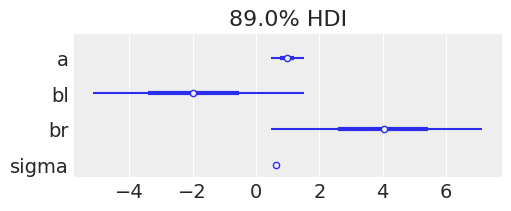

In [7]:
_ = az.plot_forest(m61_trace, combined=True, figsize=[5,2])

A multiple linear regression answers the question: *What is the value of knowing each predictor, after already knowing all of the other predictors?* . In this case, the question becomes: *What is the value of knowing each leg's length, after already knowing the other leg's length*.

Text(0, 0.5, 'Density')

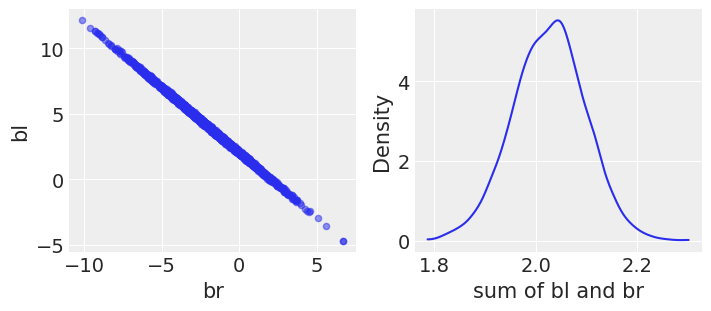

In [8]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[7,3])
ax1.scatter(m61_trace[bl], m61_trace[br], alpha=0.5, s=20)
ax1.set_xlabel("br")
ax1.set_ylabel("bl")

az.plot_kde(m61_trace[br] + m61_trace[bl], ax=ax2)
ax2.set_xlabel("sum of bl and br")
ax2.set_ylabel("Density")

The posterior distribution for these two parameters is very highly correlated, will all of the plausible values of `bl` and `br` lying along a narrow ridge. When `bl` is large, then `br` must be small. What has happened here is that since both leg variables contain almost exactly the same information, if you insist on including both in a model, then there will be a practically infinite number of combinations of `bl` and `br` that produce the same predictions.

If you fit a regression with only one of the leg length variables, you'll get approximately the same posterior mean. The basic lesson remains intact accross different simulations: **When two predictor variables are very strongly correlated, including both in a model may lead to confusion**.

In [9]:
with pm.Model() as m62:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    mu = a + bl*d.leg_left
    sigma = pm.Exponential("sigma", 1)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)
    m62_trace = pm.sample()
    idata62 = az.from_pymc3(m62_trace)
    
az.summary(idata62, round_to=2)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bl, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8891051732589544, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.90,0.34,0.38,1.44,0.01,0.01,1421.58,1391.35,1422.65,1774.98,1.0
bl,2.04,0.07,1.93,2.15,0.00,0.00,1420.10,1420.10,1423.48,1838.27,1.0
sigma,0.65,0.05,0.57,0.72,0.00,0.00,1640.96,1627.48,1636.36,1429.59,1.0


### 2. Multicolinear milk

We may not anticipate a clash between highly correlated predictors in real data sets.

In [10]:
milk = pd.read_csv('/home/telescreen/Workspace/fun/pymc-devs-resources/Rethinking_2/Data/milk.csv', sep=";")
milk['K'] = preprocessing.scale(milk['kcal.per.g'])
milk['F'] = preprocessing.scale(milk['perc.fat'])
milk['L'] = preprocessing.scale(milk['perc.lactose'])
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.956680,-1.238788,1.330401
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.830572,-1.048593,1.029186
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.145842,-1.416162,1.407153
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.019734,-1.359174,1.614963
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.263087,-0.478006,0.261666


We are concerned with the variable `perc.fat` (percent fat) and `perc.lactose` (percent lactose) that we might use to model the total energy content, `kcal.per.g`. 

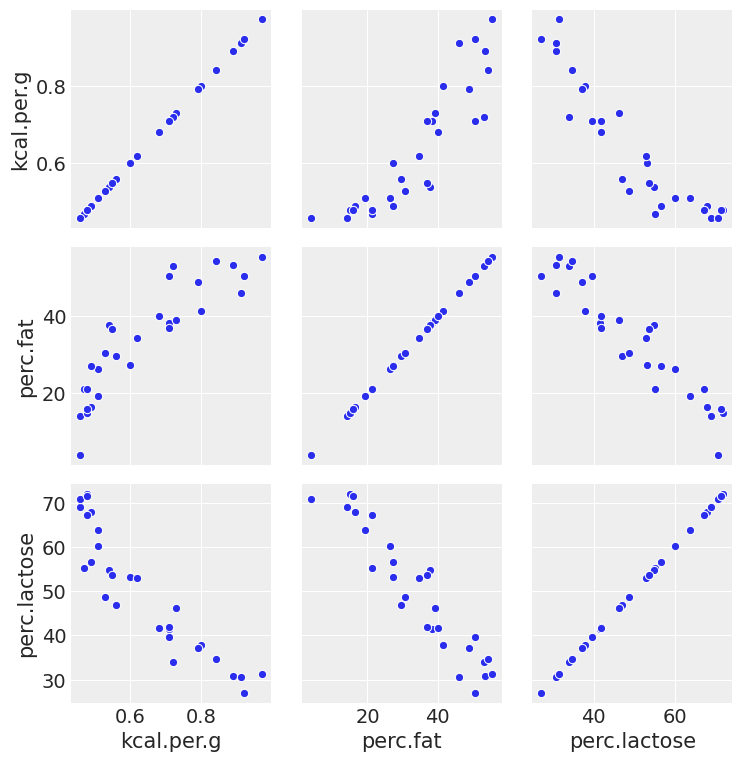

In [11]:
grid = sns.pairplot(milk, vars=['kcal.per.g', 'perc.fat', 'perc.lactose'], diag_kind=None)

In [12]:
with pm.Model() as m63:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    mu = a + bF*milk.F
    sigma = pm.Exponential("sigma", 1)
    K = pm.Normal("K", mu=mu, sigma=sigma, observed=milk.K)
    m63_trace = pm.sample()
    idata63 = az.from_pymc3(m63_trace)
    
az.summary(idata63, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.08,-0.13,0.14,0.0,0.0,4620.22,1866.12,4664.52,2848.54,1.0
bF,0.86,0.09,0.72,1.01,0.0,0.0,3977.88,3977.88,4011.35,2831.20,1.0
sigma,0.50,0.07,0.39,0.60,0.0,0.0,3684.28,3574.40,3733.25,2544.76,1.0


In [13]:
with pm.Model() as m64:
    a = pm.Normal("a", 0, 0.2)
    bL = pm.Normal("bL", 0, 0.5)
    mu = a + bL*milk.L
    sigma = pm.Exponential("sigma", 1)
    K = pm.Normal("K", mu=mu, sigma=sigma, observed=milk.K)
    m64_trace = pm.sample()
    idata64 = az.from_pymc3(m64_trace)
    
az.summary(idata64, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bL, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.07,-0.11,0.12,0.0,0.0,4275.95,1902.21,4300.22,2471.60,1.0
bL,-0.90,0.08,-1.03,-0.78,0.0,0.0,4334.71,4334.71,4355.33,2729.82,1.0
sigma,0.42,0.06,0.33,0.51,0.0,0.0,4025.55,3951.09,3987.14,2560.17,1.0


## Post-treatment Bias

It is routine to worry about mistaken inferences that arise from omitting predictor variables. Such mistakes are often called **OMITTED VARIABLE BIAS**. It is much less routine to worry about mistaken inferences arising from including variables that are consequences of other variables. We called this **POST TREATMENT BIAS**.

Post-treatment bias is important in all types of studies.
Imagine study: you want to know the difference in growht under different anti-fugal soil treatments. There are four variables of interest here: initial height, final height, treatment, and presense of fungus. Final height is the outcome of interest. If your goal is to make a causal inference about the treatment, you shouldn't include the presence of fungus, because it is a *post-treament* effect.

In [14]:
np.random.seed(71)
# Number of plants
N = 100

# Simulate initial heights
h0 = np.random.normal(10, 2, size=N)

# Assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N/2)
fungus = np.random.binomial(1, p=(0.5-treatment*0.4), size=N)
h1 = h0 + np.random.normal(5 - 3*fungus, size=N)
data = pd.DataFrame(
    np.vstack([h0, h1, treatment, fungus]).T, 
    columns=['h0', 'h1', 'treatment', 'fungus']
)
az.summary(data.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,10.15,1.67,7.28,12.44
h1,14.49,2.45,10.02,17.77
treatment,0.50,0.50,0.00,1.00
fungus,0.28,0.45,0.00,1.00


**Prior distribution**: In researc, we will not know the real data generating process. We know that the plants at time `t=1` should be tallerthan at time `t=0`. We might have a linear model like

$$ h_{1,i} \sim Normal(\mu_i, \sigma) $$
$$ \mu_i = h_{0, i} \times p $$

$h_{0,i}$ is plant $i$'s height at time $t = 0$. $h_{1,i}$ is its height at time $t = 1$, and $p$ is a parameter measuring the proportion of $h_{0,i}$ that $h_{1,i}$ is. We also have to ensure that $p > 0$ because it is a proportion.  We use Log-Normal distribution because it is always positive. If we use $p \sim \text{LogNormal}(0, 0.25)$

In [15]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))
az.summary(sim_p, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
x,1.03,0.26,0.61,1.4


In [16]:
with pm.Model() as m66:
    p = pm.Lognormal("p", 0, 0.25)
    mu = p * data.h0
    sigma = pm.Exponential("sigma", 1)
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=data.h1)
    m66_trace = pm.sample()
az.summary(m66_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,1.42,0.02,1.39,1.45,0.0,0.0,3680.12,3680.12,3678.25,2901.08,1.0
sigma,1.88,0.14,1.67,2.09,0.0,0.0,3626.71,3596.22,3655.69,2625.59,1.0


We see that `p` is approximately 40% growth on average. Let:s include both the treatment and fungus itself into the regression. We are going to make a linear model of `p` now:

$$ h_{1,i} \sim Normal(\mu_i, \sigma) $$
$$ \mu_i = h_{0, i} \times p $$
$$ p = \alpha + \beta_T T_i + \beta_F F_i $$
$$ \alpha \sim \text{LogNormal}(0, 0.25) $$
$$ \beta_T \sim \text{Normal}(0, 0.5) $$
$$ \beta_F \sim \text{Normal}(0, 0.5) $$
$$ \sigma \sim \text{Exponential}(1) $$

In [17]:
with pm.Model() as m67:
    a = pm.Lognormal("a", 0, 0.25)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)
    
    p = a + bt*data.treatment + bf*data.fungus
    
    mu = p * data.h0
    sigma = pm.Exponential("sigma", 1)
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=data.h1)
    
    m67_trace = pm.sample()
az.summary(m67_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bt,-0.02,0.03,-0.06,0.02,0.0,0.0,2272.05,1832.31,2275.24,2656.54,1.0
bf,-0.31,0.03,-0.36,-0.26,0.0,0.0,2464.52,2464.52,2462.80,2973.56,1.0
a,1.51,0.02,1.48,1.55,0.0,0.0,2139.28,2137.97,2143.72,2476.93,1.0
sigma,1.25,0.09,1.11,1.39,0.0,0.0,2643.64,2643.64,2649.06,2612.82,1.0


**Blocked by consequence**: fungus is mostly a consequence of treatment. Once we already know whether or not a plant developed fungus, does soil treatment matter? The answer is "no", because soil treatment has its effects on growth through reducing fungus. 

In [18]:
with pm.Model() as m68:
    a = pm.Lognormal("a", 0, 0.25)
    bt = pm.Normal("bt", 0, 0.5)
    
    p = a + bt*data.treatment
    
    mu = p * data.h0
    sigma = pm.Exponential("sigma", 1)
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=data.h1)
    
    m68_trace = pm.sample()
az.summary(m68_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bt,0.10,0.04,0.05,0.16,0.0,0.0,1829.45,1829.45,1833.48,1991.04,1.0
a,1.36,0.03,1.32,1.41,0.0,0.0,2050.90,2049.51,2048.87,2637.12,1.0
sigma,1.83,0.14,1.61,2.04,0.0,0.0,2492.68,2492.68,2473.51,2103.14,1.0


## Collider Bias

Selection phenomenon can happen inside a statistical model. When it does, it can seriously distort our inferences, a phenomenon known as **Collider bias**. In the trustworthiness and newsworthiness examiple, when you learn that a proposal has been selected (S), then learning its trustworthiness (T) also provides information about its newsworthiness (N). 

**Collider or false sorrow**: consider the questoin of how aging influences happiness. If we have a large survey of people rating how happy they are, is age associated with happiness?

H -> M <- A

Simulation data: 

1. Each year, 20 people are born with uniformly distributed happiness values.
2. Each year, each person ages one year. Happiness does not chagne.
3. At age 18, individuals can become married. The odds of marriage each year are proportional to an individual's happiness.
4. Once married, an individual remains married.
5. After age 65, individuals leave the sample.

In [19]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [20]:
data = sim_happiness()
data_summ = data.copy()
data_summ['married'] = data_summ['married'].astype(int)
az.summary(data_summ.to_dict(orient='list'), kind='stats', round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
age,32.00,18.77,0.0,57.00
happiness,-0.00,1.21,-2.0,1.58
married,0.28,0.45,0.0,1.00


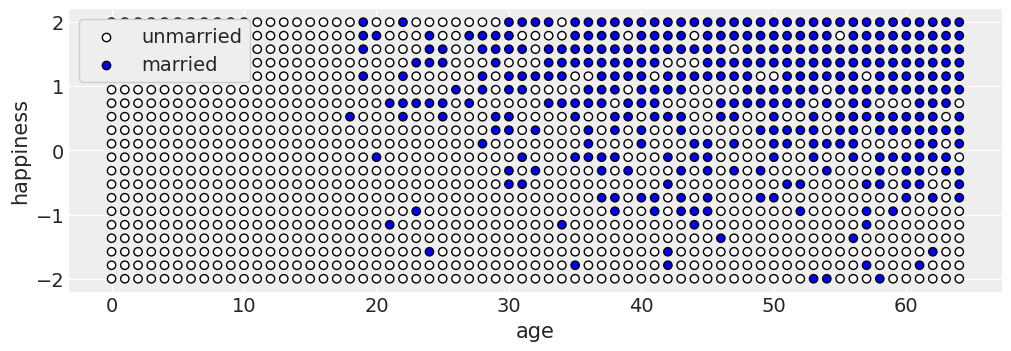

In [21]:
fig, ax = plt.subplots(figsize=[10, 3.4])
colors = np.array(['w']*data.shape[0])
colors[data.married] = 'b'
ax.scatter(data.age, data.happiness, edgecolor="k", color=colors)
ax.scatter([], [], edgecolor="k", color="w", label="unmarried")
ax.scatter([], [], edgecolor="k", color="b", label="married")
ax.legend(loc="upper left", framealpha=1, frameon=True)
ax.set_xlabel("age")
ax.set_ylabel("happiness");

In [22]:
adults = data.loc[data.age > 17].copy()
adults.age = (adults.age - 18) / (65 - 18)

In [23]:
mid = pd.Categorical(adults.loc[:, "married"].astype(int))
with pm.Model() as m69:
    a = pm.Normal("a", 0, 1, shape=2)
    bA = pm.Normal("bA", 0, 2)
    mu = a[mid] + bA*adults.age
    sigma = pm.Exponential("sigma", 1)
    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness)
    m69_trace = pm.sample()
    
az.summary(m69_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.20,0.07,-0.31,-0.09,0.0,0.0,1920.57,1846.04,1916.54,2272.91,1.0
a[1],1.21,0.09,1.07,1.37,0.0,0.0,2102.07,2102.07,2115.20,2432.77,1.0
bA,-0.72,0.12,-0.91,-0.52,0.0,0.0,1808.30,1808.30,1808.30,2021.46,1.0
sigma,1.02,0.02,0.98,1.06,0.0,0.0,2571.88,2571.88,2578.19,2115.29,1.0


The model shows that age is negatively associated with happiness (as `bA` is -0.72, less than 0). We will compare the inference of this model to the model that omits marriage status.

In [24]:
with pm.Model() as m610:
    a = pm.Normal("a", 0, 1)
    bA = pm.Normal("bA", 0, 2)
    mu = a + bA*adults.age
    sigma = pm.Exponential("sigma", 1)
    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness)
    m610_trace = pm.sample(1000)
    
az.summary(m610_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8844983238385509, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.08,-0.13,0.12,0.0,0.0,1910.00,1594.39,1911.01,2121.16,1.0
bA,0.00,0.14,-0.23,0.20,0.0,0.0,1837.43,1517.31,1836.34,2061.96,1.0
sigma,1.22,0.03,1.17,1.26,0.0,0.0,2335.58,2335.58,2333.60,2056.71,1.0


This model in contrast finds no association between age and happiness. 

It is true that mean happiness declines with age. This is because happier individuals migrate over time into the married sub-population. So in both the married and unmarried sub-populations, there is a negative relationship between age and happiness. But in neither sub-population does this accurately reflect causation.

**The haunted DAG**: Collider bias arises from conditioning on a common consequence. If we can just get our graph sorted, we can avoid it. But it isn't always so easy to see a potential collider, because there may be unmeasured causes. Unmeasured causes can still induce collider bias.

Example: Education influence of Grandparents / parents to children. The umeasured, common influences on parents and their children, such as neighborhoods, that are not shared by grandparents.

G --> P, G --> C
P --> C
U --> P, U --> C

In [25]:
N = 200
b_GP = 1   # direct effect of G on P
b_GC = 0   # direct effect of G on C
b_PC = 1   # direct effect of P on C
b_U = 2    # direct effect of U on P and C

U = 2*np.random.binomial(1, 0.5, size=N) - 1
G = np.random.normal(size=N)
P = np.random.normal(b_GP*G + b_U*U)
C = np.random.normal(b_PC*P + b_GC*G + b_U*U)
data = pd.DataFrame.from_dict({"C": C, "P": P, "G": G, "U": U})

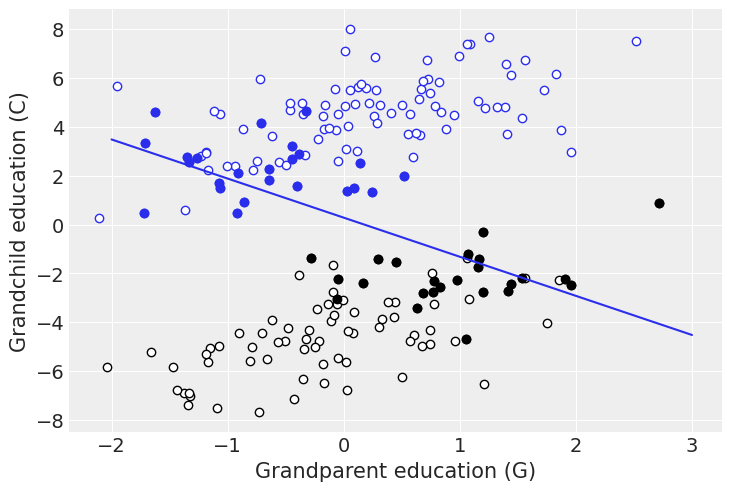

In [26]:
# Grandparent education
bad = U < 0
good = ~bad
plt.scatter(G[good], C[good], color="w", lw=1, edgecolor="C0")
plt.scatter(G[bad], C[bad], color="w", lw=1, edgecolor="k")

# Parents with similar education
eP = (P > -1) & (P < 1)
plt.scatter(G[good & eP], C[good & eP], color="C0", lw=1, edgecolor="C0")
plt.scatter(G[bad & eP], C[bad & eP], color="k", lw=1, edgecolor="k")

p = np.polyfit(G[eP], C[eP], 1)
xn = np.array([-2, 3])
plt.plot(xn, np.polyval(p, xn))
plt.xlabel("Grandparent education (G)")
plt.ylabel("Grandchild education (C)");

Unobserved confounds and collider bias. Grandparents influence grandkids only indirectly, through parents. However, unobserved neighborhood effects on parents and their children create the illusion that grandparents harm their grand kids education. Parental education is a collider: Once we condition on it, grandparental education becomes negatively associated with grandchild education.

In [27]:
with pm.Model() as m611:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)
    mu = a + p_PC*data.P + p_GC*data.G    
    sigma = pm.Exponential("sigma", 1)
    pC = pm.Normal("C", mu, sigma, observed=data.C)
    m611_trace = pm.sample()
    
az.summary(m611_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_GC, b_PC, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.11,0.10,-0.05,0.28,0.0,0.0,5432.29,3528.87,5463.36,2958.79,1.0
b_PC,1.87,0.05,1.79,1.94,0.0,0.0,4835.51,4835.51,4838.23,3379.36,1.0
b_GC,-0.85,0.11,-1.03,-0.67,0.0,0.0,4682.51,4682.51,4691.72,3463.57,1.0
sigma,1.41,0.07,1.30,1.53,0.0,0.0,4727.22,4727.22,4668.78,2759.31,1.0


The infferred effect of parents looks too big, almost twice as large as it should be. More surprising is that the model is confident that the direct effect of grandparents is to hurt their grandkids. 

**How does collider bias arise in this case?** Notice that both clouds of points show positive associations between G and C. More educated grandparents have more educated grandkids, but this effect arises entirely through parents. Conditioning on parents is like looking within sub-populations of parents with similar education. Look at highlight points of parents between 45th and 60th centiles of education and the problem is easier to recognize.

It exists because once we know P, learning G invisibly tells us about the neighborhood U and U is associated with the outcome C. 

In [28]:
with pm.Model() as m612:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)
    p_U = pm.Normal("b_U", 0, 1)
    mu = a + p_PC*data.P + p_GC*data.G + p_U * data.U
    sigma = pm.Exponential("sigma", 1)
    pC = pm.Normal("C", mu, sigma, observed=data.C)
    m612_trace = pm.sample()    
az.summary(m612_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_U, b_GC, b_PC, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.01,0.07,-0.10,0.13,0.0,0.0,3264.65,1864.59,3262.47,2541.54,1.0
b_PC,1.00,0.07,0.88,1.12,0.0,0.0,1581.42,1581.42,1582.87,1884.31,1.0
b_GC,0.09,0.11,-0.10,0.26,0.0,0.0,1741.42,1559.90,1749.44,1994.21,1.0
b_U,2.14,0.16,1.87,2.40,0.0,0.0,1761.74,1730.47,1764.89,2221.04,1.0
sigma,1.04,0.05,0.95,1.12,0.0,0.0,4378.85,4341.66,4425.50,2731.84,1.0


## Confronting Confounding

Let's define **CONFOUNDING** as any context in which the association between an outcome Y and a predictor of interest X is not the same as it would be, if we had experimentally determined the values of X. Example) we are interested in the association between education E and wages W. The problem is that in a typical population there are many unobserved variables U that influence both E and W: where a person lives, who their parents are, who their friends are. 

U --> E, U --> W, E --> W 

if we regress W on E, the estimate of the causal effect will be confounded by U. 

**Shutting the backdoor**: Blocking all confounding paths between some predictor X and some outcome Y is known as shutting the **BACKDOOR**.
There are 4 types of variable relations that combine to form all possible paths.

1. A **FORK**. X <- Z -> Y. If we condition on Z, then learning X tells us nothing about Y. X and Y are independent, conditional on Z.

2. A **PIPE** X -> Z -> Y. The treatment X influences fungus Z, which influences growth Y. If we condition on Z now, we also block the path from X to Y. So in both a fork and a pipe, conditioning of the middle variable blocks the path.

3. A **COLLIDER**: X -> Z <- Y: In a collider, there is no association between X and Y unless you condition on Z. Conditioning on Z, the collider variable, opens the path. Once the path is open, information flows between X and Y.

4. A **DESCENDENT**: X -> Z, Y -> Z, Z -> D. Controlling for D will also control, to a lesser extent for Z. The reason is that D has some information about Z. This will (partially) open the path from X to Y, because Z is a collider.

The reciple to shut the backdoor

1. List all of the paths connecting X (the potential cause of interest) and Y (the outcome)

2. Classify each path by whether it is open or closed. A path is open unless it contains a collider.

3. Classify each path by whether it is a backdoor path. A backdoor path has an arrow entering x.

4. If there are any backdoor paths that are also open, decide which variables (s) to condition on to close it.

In [29]:
from causalgraphicalmodels import CausalGraphicalModel
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
    ],
)
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

frozenset({'C'})
frozenset({'A'})
